Final Mean Squared Error (Custom Implementation): 199.0259
Final Mean Squared Error (XGBoost): 221.9135


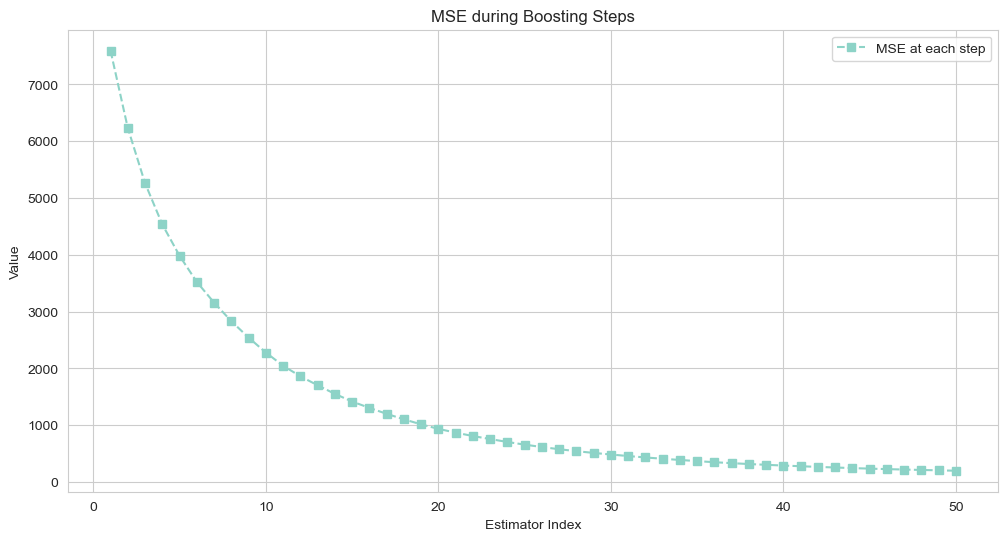


Explanation for slow MSE reduction:
1. Slow MSE reduction occurs because the model focuses on smaller residual errors as steps increase.
2. Regularization (lambda) limits weight updates, preventing overfitting but slowing convergence.
3. Learning rate limits the step size, requiring more estimators for significant improvements.


In [150]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

### also we compared Xgboost from xgboost package and our implementation

np.random.seed(42)
X, y = make_regression(n_samples=100, n_features=4, noise=10)
y = y.reshape(-1, 1)

n_estimators = 50
learning_rate = 0.2
lambda_reg = 1.0

def safe_sum(values):
    return np.sum(values) if len(values) > 0 else 0

initial_prediction = np.mean(y)
current_predictions = np.full(y.shape, initial_prediction)
mse_values = []

for estimator_idx in range(n_estimators):
    gradients = -2 * (y - current_predictions)
    hessians = np.full_like(gradients, 2)

    best_split = {"gain": -np.inf, "feature": None, "value": None}
    for feature in range(X.shape[1]):
        sorted_indices = np.argsort(X[:, feature])
        sorted_X = X[sorted_indices, feature]
        sorted_gradients = gradients[sorted_indices]
        sorted_hessians = hessians[sorted_indices]

        G_total = np.sum(sorted_gradients)
        H_total = np.sum(sorted_hessians)
        G_left, H_left = 0, 0
        G_right, H_right = G_total, H_total

        for i in range(1, len(sorted_X)):
            G_left += sorted_gradients[i - 1]
            H_left += sorted_hessians[i - 1]
            G_right = G_total - G_left
            H_right = H_total - H_left

            if sorted_X[i] != sorted_X[i - 1]:
                gain = (
                    (G_left ** 2) / (H_left + lambda_reg) +
                    (G_right ** 2) / (H_right + lambda_reg) -
                    (G_total ** 2) / (H_total + lambda_reg)
                )
                if gain > best_split["gain"]:
                    best_split = {
                        "gain": gain,
                        "feature": feature,
                        "value": (sorted_X[i] + sorted_X[i - 1]) / 2
                    }

    split_index = best_split["feature"]
    split_value = best_split["value"]

    left_mask = X[:, split_index] <= split_value
    right_mask = X[:, split_index] > split_value

    if not np.any(left_mask) or not np.any(right_mask):
        continue

    left_gradients = gradients[left_mask]
    right_gradients = gradients[right_mask]

    left_hessians = hessians[left_mask]
    right_hessians = hessians[right_mask]

    left_weight = -safe_sum(left_gradients) / (safe_sum(left_hessians) + lambda_reg)
    right_weight = -safe_sum(right_gradients) / (safe_sum(right_hessians) + lambda_reg)

    updates = np.zeros_like(y)
    updates[left_mask] = left_weight
    updates[right_mask] = right_weight
    current_predictions += learning_rate * updates

    mse = np.mean((y - current_predictions) ** 2)
    mse_values.append(mse)

final_mse = np.mean((y - current_predictions) ** 2)

print(f"Final Mean Squared Error (Custom Implementation): {final_mse:.4f}")

# Compare with XGBoost
xgb_model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=1, reg_lambda=lambda_reg, objective='reg:squarederror')
xgb_model.fit(X, y.ravel())

xgb_predictions = xgb_model.predict(X)
xgb_mse = np.mean((y.ravel() - xgb_predictions) ** 2)

print(f"Final Mean Squared Error (XGBoost): {xgb_mse:.4f}")

# Visualization MSE reduction
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(mse_values) + 1), mse_values, marker='s', label='MSE at each step', linestyle='--')
plt.xlabel('Estimator Index')
plt.ylabel('Value')
plt.title('MSE during Boosting Steps')
plt.legend()
plt.grid(True)
plt.show()

# Explanation for slow MSE reduction:
print("\nExplanation for slow MSE reduction:")
print("1. Slow MSE reduction occurs because the model focuses on smaller residual errors as steps increase.")
print("2. Regularization (lambda) limits weight updates, preventing overfitting but slowing convergence.")
print("3. Learning rate limits the step size, requiring more estimators for significant improvements.")


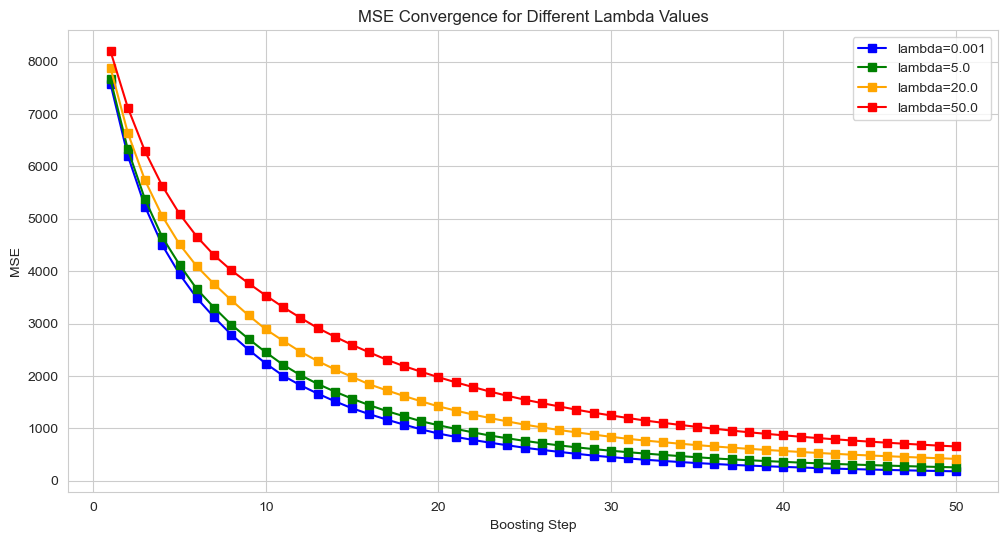

In [ ]:
### MSE convergence depends on lambda ->

learning_rate = 0.2

def safe_sum(values):
    return np.sum(values) if len(values) > 0 else 0

# Lambda values for testing
lambda_values = [0.001, 5.0, 20.0, 50.0]
results = {}
colors = ['blue', 'green', 'orange', 'red']  # Predefined colors for lines

for lambda_reg in lambda_values:
    current_predictions = np.full(y.shape, np.mean(y))
    mse_values = []

    for estimator_idx in range(n_estimators):
        gradients = -2 * (y - current_predictions)
        hessians = np.full_like(gradients, 2)

        best_split = {"gain": -np.inf, "feature": None, "value": None}
        for feature in range(X.shape[1]):
            sorted_indices = np.argsort(X[:, feature])
            sorted_X = X[sorted_indices, feature]
            sorted_gradients = gradients[sorted_indices]
            sorted_hessians = hessians[sorted_indices]

            G_total = np.sum(sorted_gradients)
            H_total = np.sum(sorted_hessians)
            G_left, H_left = 0, 0
            G_right, H_right = G_total, H_total

            for i in range(1, len(sorted_X)):
                G_left += sorted_gradients[i - 1]
                H_left += sorted_hessians[i - 1]
                G_right = G_total - G_left
                H_right = H_total - H_left

                if sorted_X[i] != sorted_X[i - 1]:
                    gain = (
                        (G_left ** 2) / (H_left + lambda_reg) +
                        (G_right ** 2) / (H_right + lambda_reg) -
                        (G_total ** 2) / (H_total + lambda_reg)
                    )
                    if gain > best_split["gain"]:
                        best_split = {
                            "gain": gain,
                            "feature": feature,
                            "value": (sorted_X[i] + sorted_X[i - 1]) / 2
                        }

        split_index = best_split["feature"]
        split_value = best_split["value"]

        left_mask = X[:, split_index] <= split_value
        right_mask = X[:, split_index] > split_value

        if not np.any(left_mask) or not np.any(right_mask):
            continue

        left_gradients = gradients[left_mask]
        right_gradients = gradients[right_mask]

        left_hessians = hessians[left_mask]
        right_hessians = hessians[right_mask]

        left_weight = -safe_sum(left_gradients) / (safe_sum(left_hessians) + lambda_reg)
        right_weight = -safe_sum(right_gradients) / (safe_sum(right_hessians) + lambda_reg)

        updates = np.zeros_like(y)
        updates[left_mask] = left_weight
        updates[right_mask] = right_weight
        current_predictions += learning_rate * updates

        mse = np.mean((y - current_predictions) ** 2)
        mse_values.append(mse)

    results[lambda_reg] = mse_values

# Plot MSE convergence for different lambda values
plt.figure(figsize=(12, 6))
for i, (lambda_reg, mse_values) in enumerate(results.items()):
    plt.plot(range(1, len(mse_values) + 1), mse_values, label=f'lambda={lambda_reg}', color=colors[i], marker='s')
plt.xlabel('Boosting Step')
plt.ylabel('MSE')
plt.title('MSE Convergence for Different Lambda Values')
plt.legend()
plt.grid(True)
plt.show()


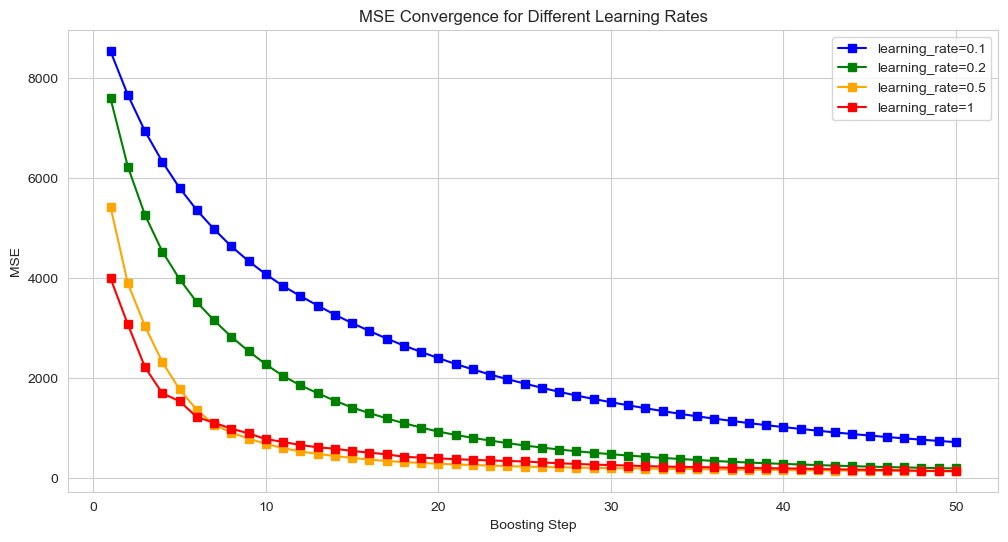

In [156]:
### MSE convergence depends on learning rate ->

lambda_reg = 1.0

def safe_sum(values):
    return np.sum(values) if len(values) > 0 else 0

# Learning rate values for testing
learning_rates = [ 0.1, 0.2, 0.5, 1]
results = {}
colors = ['blue', 'green', 'orange', 'red']  # Predefined colors for lines

for learning_rate in learning_rates:
    current_predictions = np.full(y.shape, np.mean(y))
    mse_values = []

    for estimator_idx in range(n_estimators):
        gradients = -2 * (y - current_predictions)
        hessians = np.full_like(gradients, 2)

        best_split = {"gain": -np.inf, "feature": None, "value": None}
        for feature in range(X.shape[1]):
            sorted_indices = np.argsort(X[:, feature])
            sorted_X = X[sorted_indices, feature]
            sorted_gradients = gradients[sorted_indices]
            sorted_hessians = hessians[sorted_indices]

            G_total = np.sum(sorted_gradients)
            H_total = np.sum(sorted_hessians)
            G_left, H_left = 0, 0
            G_right, H_right = G_total, H_total

            for i in range(1, len(sorted_X)):
                G_left += sorted_gradients[i - 1]
                H_left += sorted_hessians[i - 1]
                G_right = G_total - G_left
                H_right = H_total - H_left

                if sorted_X[i] != sorted_X[i - 1]:
                    gain = (
                        (G_left ** 2) / (H_left + lambda_reg) +
                        (G_right ** 2) / (H_right + lambda_reg) -
                        (G_total ** 2) / (H_total + lambda_reg)
                    )
                    if gain > best_split["gain"]:
                        best_split = {
                            "gain": gain,
                            "feature": feature,
                            "value": (sorted_X[i] + sorted_X[i - 1]) / 2
                        }

        split_index = best_split["feature"]
        split_value = best_split["value"]

        left_mask = X[:, split_index] <= split_value
        right_mask = X[:, split_index] > split_value

        if not np.any(left_mask) or not np.any(right_mask):
            continue

        left_gradients = gradients[left_mask]
        right_gradients = gradients[right_mask]

        left_hessians = hessians[left_mask]
        right_hessians = hessians[right_mask]

        left_weight = -safe_sum(left_gradients) / (safe_sum(left_hessians) + lambda_reg)
        right_weight = -safe_sum(right_gradients) / (safe_sum(right_hessians) + lambda_reg)

        updates = np.zeros_like(y)
        updates[left_mask] = left_weight
        updates[right_mask] = right_weight
        current_predictions += learning_rate * updates

        mse = np.mean((y - current_predictions) ** 2)
        mse_values.append(mse)

    results[learning_rate] = mse_values

# Plot MSE convergence for different learning rates
plt.figure(figsize=(12, 6))
for i, (learning_rate, mse_values) in enumerate(results.items()):
    plt.plot(range(1, len(mse_values) + 1), mse_values, label=f'learning_rate={learning_rate}', color=colors[i], marker='s')
plt.xlabel('Boosting Step')
plt.ylabel('MSE')
plt.title('MSE Convergence for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()
